Version 2.0 March 26th, 2024

# CTD corrections applied to delayed mode data
- deployment: dfo-mike579-20210704
- glider: dfo-mike579
- sensor: CTD_9309
- description: Calvert Island Line

# 1.0 Preamble
This document describes conductivity, temperature, and pressure data processing steps applied to delayed mode data collected using Sea-Bird Scientific Glider Payload Conductivity Temperature Depth (GPCTD) sensors mounted on C-PROOF Slocum and SeaExplorer autonomous ocean gliders. This sensor has a nominal sampling rate of 1 Hz and was designed specifically for Slocum gliders. This document covers the application of the sensor alignment correction and the thermal lag correction, as well as removal of questionable conductivity values and salinity profiles.

In [1]:
deploy_name = 'dfo-mike579-20210704'
glider_name = 'dfo-mike579'
deploy_prefix = './'
processing_report = 'CTD_dfo-mike579-20210704_v2'
processing_date = '20240326'
processing_protocol = 'C-PROOF_SBE_CTDProcessingReport_v0.2.pdf'

## 1.1 Set up the processing

The processing steps below are applied to delayed mode data stored in a single netcdf timeseries file created using the Pyglider data processing package (https://github.com/c-proof/pyglider). The metadata and sensor calibration sheets are available via the deployment page on the C-PROOF website: **https://cproof.uvic.ca/gliderdata/deployments/dfo-mike579/dfo-mike579-20210704/**.

In [2]:
import warnings
#warnings.filterwarnings('ignore')

import xarray as xr
import numpy as np
import pathlib
import pyglidersensor as pgs

from datetime import datetime

import scipy.stats as stats
import scipy.optimize as optimize

import seawater

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import cmocean

%load_ext autoreload
%autoreload 2

## 1.2 Profile Check

Check that upcasts and downcasts are being properly identified.
Negative values should be associated with upcasts, and indeed we can see that that is the case here. 

There are 1195042 data points in total.
Fig. 1: Identifying upcasts and downcasts. The left panel shows pressure vs. time and the right panel shows profile direction vs. time for a small subset of the time series.


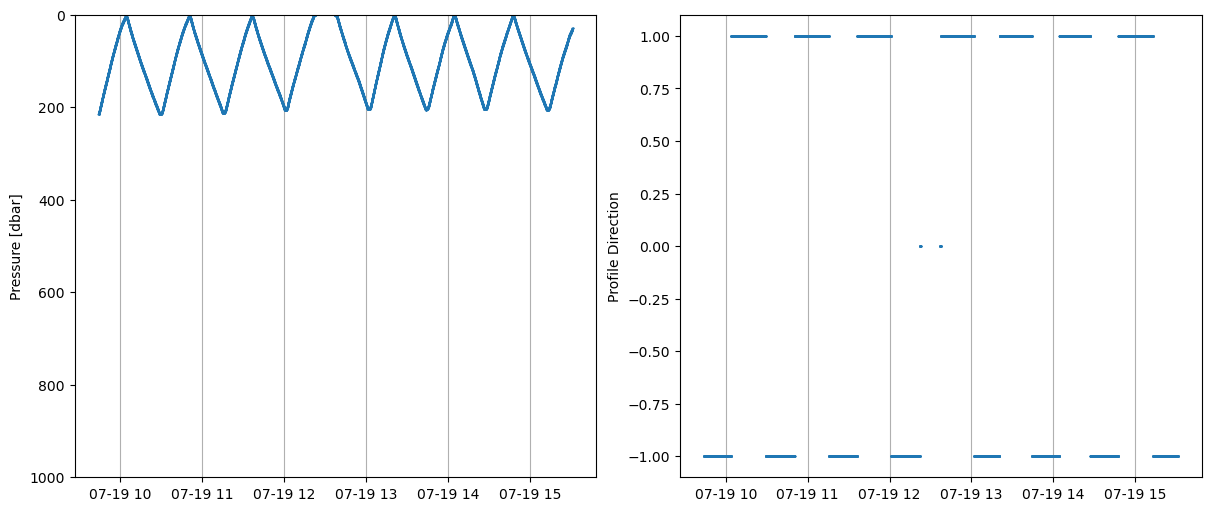

In [3]:
caption = ('Fig. 1: Identifying upcasts and downcasts. The left panel shows '
           'pressure vs. time and the right panel shows profile direction vs. '
           'time for a small subset of the time series.')

fname = f'{deploy_prefix}/{deploy_name}_delayed.nc'

with xr.open_dataset(fname) as ds0:
    N = len(ds0.time)
    print(f'There are {N} data points in total.')
    
    if N > 50000:
        todo = slice(int(N/2)-5000, int(N/2)+5000)
    else:
        todo = slice(int(N/3), int(2*N/3))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, 
                            constrained_layout=True, 
                            figsize=(12, 5))

    ds = ds0.isel(time=todo)
    axs[0].plot(ds.time, ds.pressure, '.', markersize=1)
    axs[0].set_ylim([1000, 0])
    axs[0].set_ylabel('Pressure [dbar]')
    axs[0].grid(axis='x')

    axs[1].plot(ds.time, ds.profile_direction, '.', markersize=1)
    axs[1].set_ylabel('Profile Direction')
    axs[1].grid(axis='x') 
    print(caption)

# 2.0 Corrections applied to delayed mode data for this mission
1. Identification of anomalous conductivity values
2. Sensor alignment correction
3. Identification of questionable salinity profiles 
4. Thermal lag correction

## 2.1 Identification and removal of anomalous conductivity values

We identify and remove any conductivity values that are obviously unphysical, which is typically caused by air bubbles in the conductivity cell. We use a simple criterion applied to the raw conductivity data. The criterion temporarily flags any data points that are more than **5 standard deviations** away from the overall time series mean for a given depth bin and profile bin, then recomputes the mean and standard deviation, excluding the temporarily flagged values. Conductivity values that still differ from the mean by more than **3 standard deviations** are flagged as 'bad' and set to NaN in the time series. If the difference between the 'bad' values and the mean is less than the accuracy of the sensor, which is 0.0003 S/m for the GPCTD, then those points are not excluded.

This criterion is applied to data binned first by profile index, in increments of **50 profiles**, then binned by depth, in increments of **5 m**. The use of profile index bins rather than time or temperature bins is designed to allow for the removal of unphysical values in both **Hakai Pass** and crossing the continental shelf in **Queen Charlotte Sound**, two mission segments where the distributions of conductivity differ significantly. 

In [10]:
# Identify the questionable conductivity values
flag_stdev = 5 #number of standard deviations to temporarily flag bad salinity values 
clean_stdev = 3 #number of standard deviations to flag bad conductivity values, after removing the temporary bad values from the calc
dT = 50 #size of the profile bins
dz = 5 #size of the depth bins
accuracy = 0.0003 #accuracy of the sensor is 0.0003, used as a cutoff on the exclusion criterion

ts0 = pgs.get_timeseries(deploy_prefix, deploy_name)
ts0.conductivity[ts0.conductivity<0.01] = np.nan
ts = pgs.get_conductivity_clean(ts0, dT, dz, flag_stdev, clean_stdev, accuracy)
ts.to_netcdf('conductivityClean.nc')

C:\Users\Hayley\Documents\CPROOFDFO\cproof_glider_anlysis\slocum_notebook_main\dfo-mike579\dfo-mike579-20210704\pyglidersensor.py:42: RuntimeWarning: Mean of empty slice
  cond_mean = np.nanmean(cond_z)
C:\Users\Hayley\miniconda3\envs\pyglider2\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Hayley\Documents\CPROOFDFO\cproof_glider_anlysis\slocum_notebook_main\dfo-mike579\dfo-mike579-20210704\pyglidersensor.py:46: RuntimeWarning: Mean of empty slice
  ind_bad = np.logical_and(np.fabs(cond_z-np.nanmean(cond_z[~ind_flag])) >
C:\Users\Hayley\Documents\CPROOFDFO\cproof_glider_anlysis\slocum_notebook_main\dfo-mike579\dfo-mike579-20210704\pyglidersensor.py:48: RuntimeWarning: Mean of empty slice
  np.fabs(cond_z-np.nanmean(cond_z[~ind_flag])) > accuracy)


Fig. 2: Temperature vs. conductivity (left), depth vs. conductivity (middle), and conductivity vs. profile index (right), with the red dots showing the unphysical values flagged as bad and removed.


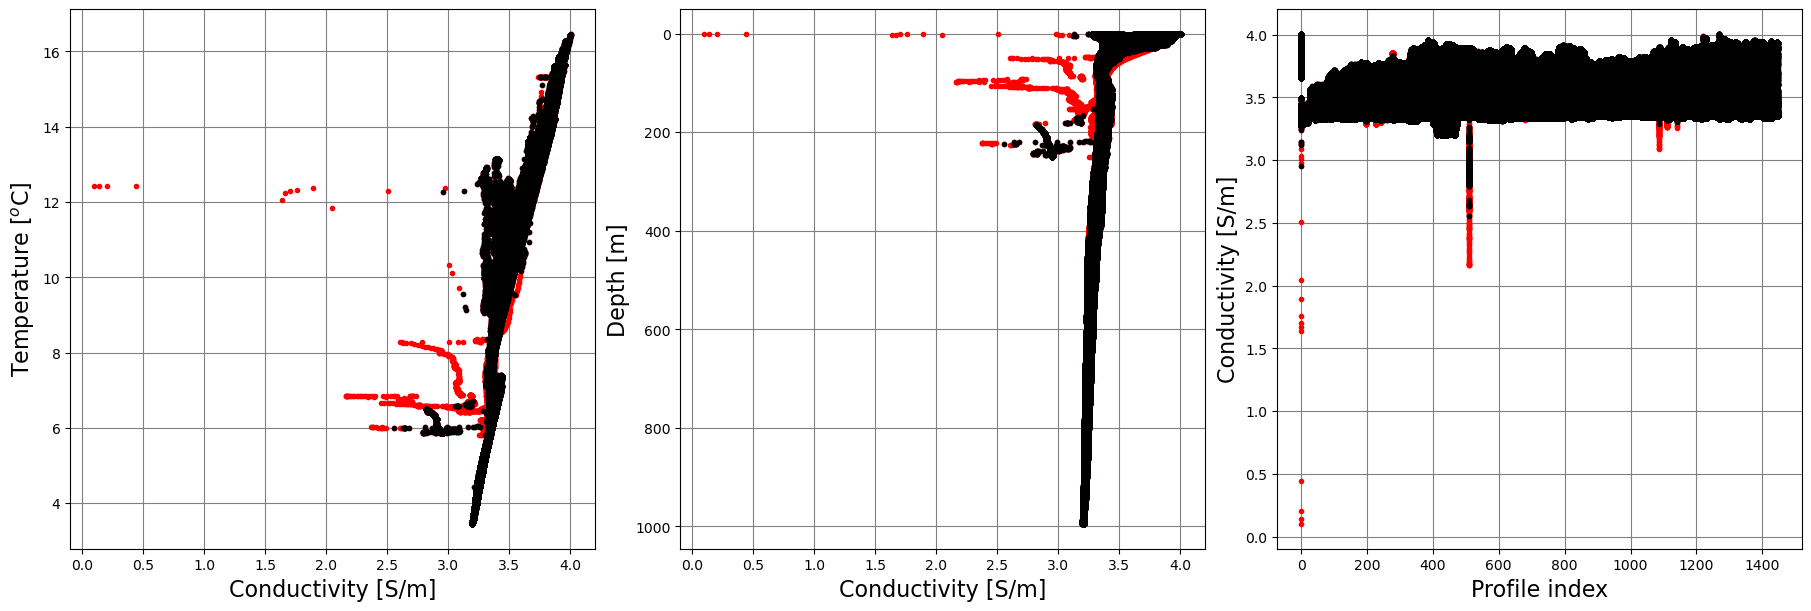

In [11]:
# Figures to look at the comparison    
fig, ax = plt.subplots(1,3,figsize=(18,6), constrained_layout=True)

ax[0].plot(ts.conductivity, ts.temperature, color='r', marker='.', linestyle='none')
ax[0].plot(ts.conductivityClean, ts.temperature, color='k', marker='.', linestyle='none')
ax[0].set_ylabel('Temperature [$^o$C]', fontsize=16)
ax[0].set_xlabel('Conductivity [S/m]', fontsize=16)
ax[0].grid(axis='both', color='0.5')

ax[1].plot(ts.conductivity, ts.depth, color='r', marker='.', linestyle='none')
ax[1].plot(ts.conductivityClean, ts.depth, color='k', marker='.', linestyle='none')
ax[1].set_xlabel('Conductivity [S/m]', fontsize=16)
ax[1].set_ylabel('Depth [m]', fontsize=16)
ax[1].invert_yaxis()
ax[1].grid(axis='both', color='0.5')

ax[2].plot(ts.profile_index, ts.conductivity, color='r', marker='.', linestyle='none')
ax[2].plot(ts.profile_index, ts.conductivityClean, color='k', marker='.', linestyle='none')
ax[2].set_xlabel('Profile index', fontsize=16)
ax[2].set_ylabel('Conductivity [S/m]', fontsize=16)
ax[2].grid(axis='both', color='0.5')

print('Fig. 2: Temperature vs. conductivity (left), depth vs. conductivity (middle), '
      'and conductivity vs. profile index (right), '
      'with the red dots showing the unphysical values flagged as bad and removed.')

Adjustments to this correction are based on examining the data and making a judgment call about which conductivity values are undeniably 'bad'. In this case, we want to exclude the **extremely low values occurring at the surface** (Fig. 2) consistent with air bubbles in the cell. Some unphysical values are missed by this correction, such as the **sudden drops in conductivity between the surface and 250 m**, and can be caught during the removal of unphysical salinity profiles below. 

**NOTE that for this mission, the sampling rate of the GPCTD is one sample every 2s!**

In [8]:
srate = stats.mode((np.diff(ts.time)).astype('timedelta64[s]')).mode
print(f'The mode of the sampling rate for the GPCTD is one sample every {srate}.')

The mode of the sampling rate for the GPCTD is one sample every 2 seconds.


## 2.2 Sensor alignment correction

We now apply the sensor alignment correction. This correction is used to align the temperature and conductivity in time, relative to the pressure. This correction reduces the occurrence of salinity spikes near sharp gradients in T and S and ensures calculations are made using the same parcel of water for all variables. The misalignment between the sensors is caused by 1) the physical separation between sensors causing a transit time delay for water being pumped through the CTD and 2) different sensor response times. 

GPCTD specs are as follows: 
+ Nominal sampling rate is 1 Hz (0.5 Hz for this mission)
+ Pumped flow-rate through the sensors is 10 ml/s 

Janzen and Creed (2011) provide constants used for the GPCTD sensor alignment correction "... based on the transit time between the T-C sensors, the temperature response time, and the estimated response time of the conductivity sensor in a 10 ml/s flow." The following constants are used for their Sea-Bird GPCTD alignment corrections: 
+ Temperature advanced by +0.5 s relative to pressure
+ Conductivity advanced by +0.4 s relative to pressure

**Our procedure for the alignment correction**:
1. Directly estimate the sensor alignment correction constant for conductivity relative to temperature, $\tau_C$ 
2. Confirm that the directly estimated value of $\tau_C$ is within 0.5s of the Janzen and Creed (2011) value of -0.1s (if the directly estimated value for a given sensor is consistently higher or lower than -0.1s, investigate further)
3. Apply the alignment correction using the alignment constants for conductivity and temperature provided in Janzen and Creed (2011) 

We **apply the correction** using a linear time interpolation method, based on the one in the Sea-Bird CTD data processing manual and the Sea-Bird CTD-processing toolbox on Github 
(https://github.com/rejectedbanana/Sea-Bird-Toolbox/blob/master/CTD_PROCESSING/SBE_alignCTDW.m).

We determine the correction using only water below the highly variable near-surface layer, which is approximately identified using the T-S diagram below. We choose as an isopycnal cutoff a value above the main thermocline, but which excludes that highly variable surface layer:

Fig. 3: Temperature vs. salinity diagram.  Black contours give density in kg/m^3.


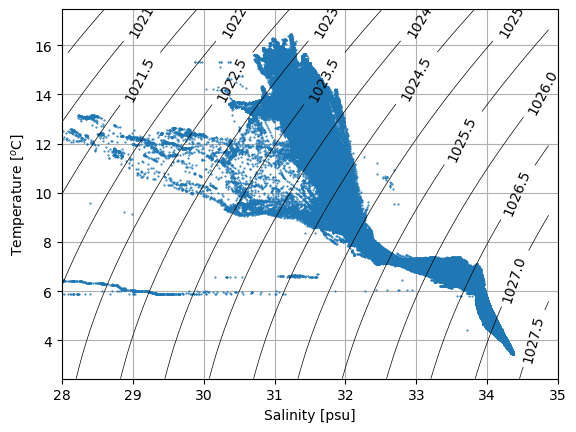

In [12]:
# T-S diagram to select near-surface water density range to exclude
plt.plot(ts.salinity,ts.temperature,'.',markersize=1)

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.min(ts.salinity)-0.5, 
                      np.max(ts.salinity)+0.5, 1000)
T_range = np.linspace(np.min(ts.temperature)-1, 
                      np.max(ts.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

CS = plt.contour(S_range, T_range, density_grid,
                np.arange(1014,
                          np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.xlabel('Salinity [psu]')
plt.ylabel('Temperature [$^o$C]')
plt.xlim(28,35)
plt.grid()
print('Fig. 3: Temperature vs. salinity diagram. ',
     'Black contours give density in kg/m^3.')

**Step 1: directly estimate the sensor alignment correction constant** following the methodology of Ferrari and Rudnick (2000):

1. Assume conductivity is approximately linearly related to temperature
2. Calculate the cross-spectrum between the standardized temperature and conductivity timeseries 
3. Calculate the coherence, to determine where the cross-spectrum is valid
4. Fit the function $2 \pi f \tau_C$ to the phase of the cross-spectrum, where $f$ is frequency and $\tau_C$ is the correction constant we are looking for

These steps are applied to each individual profile, with fresh surface water **less dense than 1023 kg/m$^3$** excluded based on the T-S diagram (Fig. 3). The cross-spectrum is estimated using Welch's method, with a Hann window of **length 128 and 50% overlap**. The spectrogram (Fig. 4) shows only values for which the coherence is **at least 75%** and exceeds the 95% confidence level. The choice of 75% is arbitrary, and results are not sensitive to this choice within the range 50% to 90%. 

In [13]:
#Set up the important constants for the analysis
n = 128 #segment length for ffts
density_cutoff = 1023 #exclude everything less dense than this from the minimization
num_profs = int(np.nanmax(ts.profile_index)) #number of profiles to include in the subset of data
clean_profs_start = 0 #number of profiles to exclude from the start
clean_profs_end = 0 #number of profiles to exclude from the end
c_val = 0.75 #our cutoff value for coherence as a fraction of 1
fs = 1/srate.astype(float) #the sampling frequency = 1/(delta t)
freq = np.linspace(0,0.50,100)*fs #frequency range to interpolate onto for plotting

Applying density cutoff
Total number of profiles: 1447
Ready to loop over profiles


C:\Users\Hayley\miniconda3\envs\pyglider2\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 128 is greater than input length  = 126, using nperseg = 126
  warnings.warn('nperseg = {0:d} is greater than input length '


Plotting
Fig. 4: Spectrogram for T and C cross-spectrum magnitude (top), phase (middle), and squared coherence (bottom) as a function of frequency and profile index. Only points exceeding the 95% confidence level and with coherence above 75% are shown.


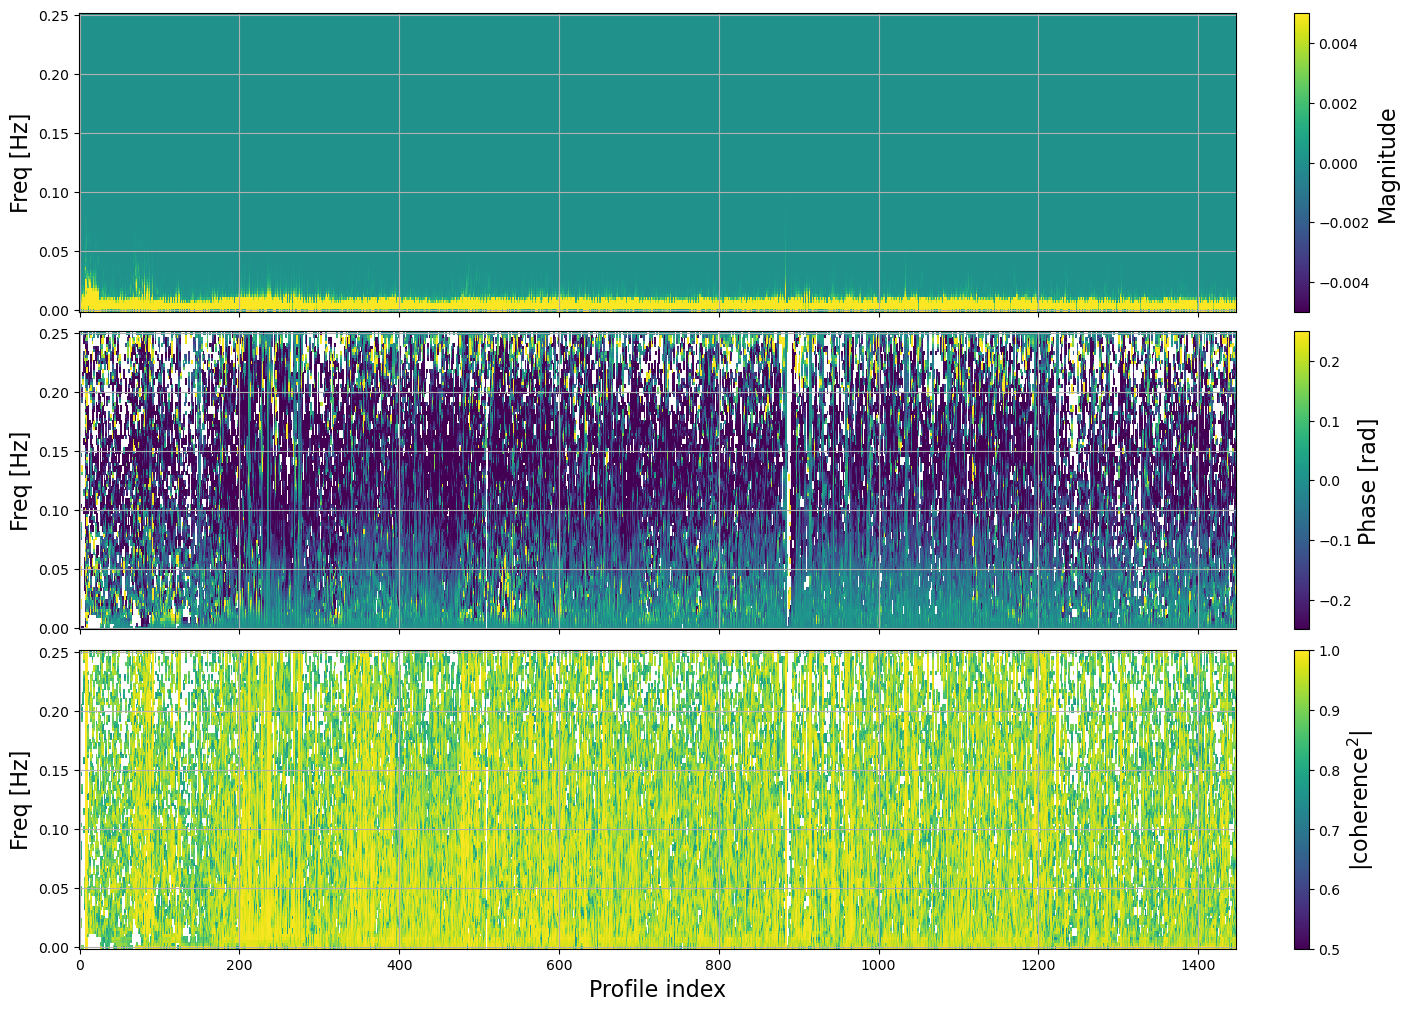

In [14]:
#Spectrogram with density cutoff for chosen subset of profiles
fname = "conductivityClean.nc"

mag_all, phase_all, coh_all, profile_bins = pgs.get_spectrogram(
    fname, n, density_cutoff, clean_profs_start, 
    clean_profs_end, num_profs, fs, c_val, freq,
)

fig, axs = plt.subplots(nrows=3, ncols=1, 
                            constrained_layout=True, 
                            figsize=(14, 10), sharex=True)

print('Plotting')
c0 = axs[0].pcolor(profile_bins, freq, mag_all, vmin=-0.005, vmax=0.005);
cb = plt.colorbar(c0,ax=axs[0])
cb.set_label('Magnitude', fontsize=16)
axs[0].set_ylabel('Freq [Hz]', fontsize=16)
axs[0].grid()

c1 = axs[1].pcolor(profile_bins, freq, phase_all, vmin=-0.25, vmax=0.25);
cb1 = plt.colorbar(c1,ax=axs[1])
cb1.set_label('Phase [rad]', fontsize=16)
axs[1].set_ylabel('Freq [Hz]', fontsize=16)
axs[1].grid()

c2 = axs[2].pcolor(profile_bins, freq, coh_all, vmin=0.5, vmax=1.0);
cb2 = plt.colorbar(c2,ax=axs[2])
cb2.set_label('|coherence$^2$|', fontsize=16)
axs[2].set_ylabel('Freq [Hz]', fontsize=16)
axs[2].set_xlabel('Profile index', fontsize=16)
axs[2].grid()

print('Fig. 4: Spectrogram for T and C cross-spectrum magnitude (top), '
      'phase (middle), and squared coherence (bottom) '
      'as a function of frequency and profile index. Only points exceeding '
      'the 95% confidence level and with coherence above 75% are shown.') 

The value of tau_C is -0.30027 with standard error 0.00101.
Fig. 5: Cross-spectrum phase of temperature and conductivity plotted as small gray points, with the mean plotted as large dots coloured by mean squared-coherence. The gray envelope shows the standard error for the mean over all profiles. The red line shows the function fit to points for which the frequency is less than the chosen cutoff. 


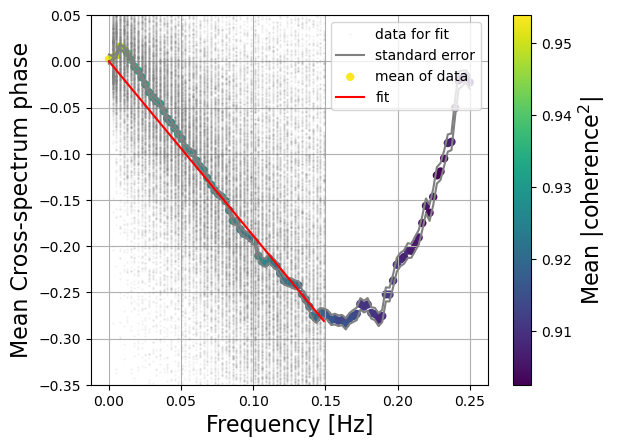

In [15]:
# Calcuate tau_C and plot the fit
freq_cut = 0.3
tau_C, covariance, fr_fld, fld, fit_y = pgs.get_tau_C(freq, freq_cut, fs, phase_all)

SE = np.sqrt(np.diag(covariance))
SE_A = SE[0]
print(f'The value of tau_C is {tau_C:.5f} with standard error {SE_A:.5f}.')

std_err = np.nanstd(phase_all,axis=1)/np.sqrt(np.shape(phase_all)[1])
plt.plot(fr_fld,fld,'.',color='gray',markersize=1,alpha=0.1,label='data for fit')
plt.plot(freq, np.nanmean(phase_all,axis=1)+std_err, '-', color='gray', 
         label='standard error')
plt.plot(freq, np.nanmean(phase_all,axis=1)-std_err, '-', color='gray')
plt.scatter(freq, np.nanmean(phase_all,axis=1), 25, np.nanmean(coh_all,axis=1), 
            label='mean of data')
plt.ylim(-0.35,0.05)
ax = plt.plot(fr_fld, fit_y, '-r', label='fit')
cb = plt.colorbar()
cb.set_label('Mean |coherence$^2$|', fontsize=16)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Mean Cross-spectrum phase', fontsize=16)
plt.grid()
plt.legend()
print('Fig. 5: Cross-spectrum phase of temperature and conductivity plotted ' 
      'as small gray points, with the mean plotted as large dots coloured by '
      'mean squared-coherence. The gray envelope shows the standard error for '
      'the mean over all profiles. The red line shows the function fit to points '
      'for which the frequency is less than the chosen cutoff. ')

We fit the function only to frequencies **below 0.15 Hz** (Fig. 5). Above this frequency, we lose coherence and the slope of the cross-spectrum phase changes sign. We see that the resulting value for the **time constant $\tau_C = -0.32$ s** is well within the required $\pm 0.5$ s of the value specified for Sea-Bird GPCTDs, $\tau_C = -0.1$ s. 

**Step 2**: We can thus **confirm the Janzen and Creed (2011) constants** for the alignment correction are appropriate for use with this GPCTD. We preferentially use the Janzen and Creed (2011) constants over our directly estimated value for $\tau_C$ since we have found that the direct estimate is sensitive to the choices of frequency and density cutoff used, with reasonable choices producing constants that can vary by up to $\pm 0.5$ s. 

**Step 3**: Apply the correction using the alignment constants for conductivity and temperature provided in Janzen and Creed (2011). Specifically, advance conductivity by 0.4 s relative to pressure and advance temperature by 0.5 s relative to pressure. Figure 6 shows the magnitude of the change in temperature and salinity as a result of the sensor alignment correction. The changes in both fields are large enough to be significant for many data points. 

In [16]:
# Apply alignment correction. This linear interpolation approach is taken from the Sea-Bird
# CTD-processing toolbox on Github 
# (https://github.com/rejectedbanana/Sea-Bird-Toolbox/blob/master/CTD_PROCESSING/SBE_alignCTDW.m)
fname = 'conductivityClean.nc'
advance_C = 0.4
advance_T = 0.5

ds1 = pgs.alignment_correction(fname, srate, advance_C, advance_T)

Fig. 6: Left panel shows temperature vs. salinity diagram, where black contours give density in kg/m^3. Right panel shows  the difference between the aligned and uncorrected temperature vs. the difference between the aligned and uncorrected salinity.


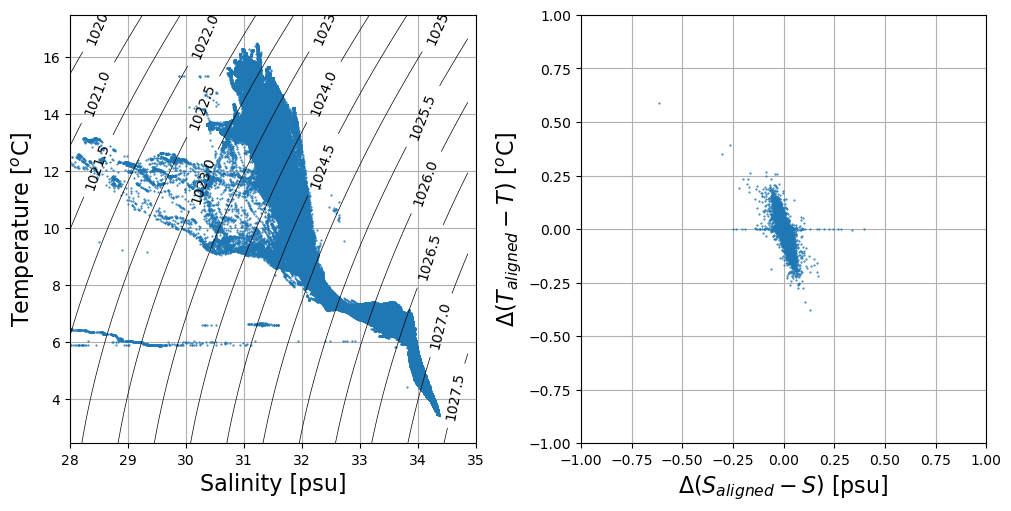

In [17]:
# T-S diagram showing correction magnitude
fig, ax = plt.subplots(nrows=1, ncols=2, 
                            constrained_layout=True, 
                            figsize=(10, 5))

ax[0].plot(ds1.salinity,ds1.temperature,'.',markersize=1)

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.min(ds1.salinity)-0.5, 
                      np.max(ds1.salinity)+0.5, 1000)
T_range = np.linspace(np.min(ds1.temperature)-1, 
                      np.max(ds1.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

CS = ax[0].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[0].clabel(CS, CS.levels, inline=True, fontsize=10)
ax[0].set_xlabel('Salinity [psu]', fontsize=16)
ax[0].set_ylabel('Temperature [$^o$C]', fontsize=16)
ax[0].set_xlim(28,35)
ax[0].grid()

ds0 = ts.copy(deep=True)
ds0 = ds0.where(np.isfinite(ds0.temperature + 
                            ds0.conductivity), drop=True)

ax[1].plot(ds1.salinity-ds0.salinity,ds1.temperature-ds0.temperature,'.',markersize=1)
ax[1].set_xlabel('$\Delta (S_{aligned} - S$) [psu]', fontsize=16)
ax[1].set_ylabel('$\Delta (T_{aligned} - T$) [$^o$C]', fontsize=16)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)
ax[1].grid()
print('Fig. 6: Left panel shows temperature vs. salinity diagram,',
      'where black contours give density in kg/m^3. Right panel shows ',
      'the difference between the aligned and uncorrected temperature vs.',
      'the difference between the aligned and uncorrected salinity.')

Fig. 7: Upcast and downcast of temperature, conductivity, and salinity vs. pressure, for part of the upper water column. Black indicates uncorrected fields, and blue indicates fields for which an alignment has been applied. Final panel shows the difference between the aligned and uncorrected salinity.


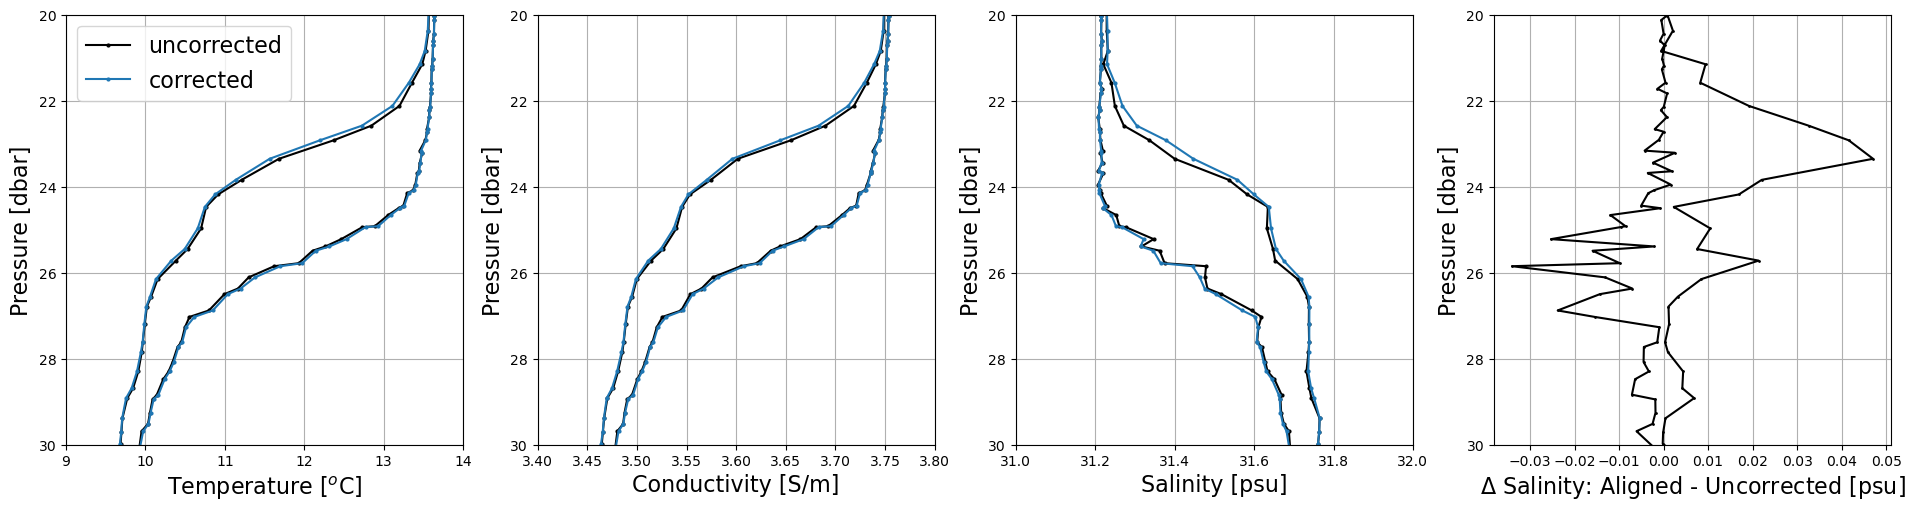

In [18]:
# Compare data before after alignment correction is applied
# ds1 = corrected, ds0 = uncorrected
ds0 = ts.copy(deep=True)
ds0 = ds0.where(np.isfinite(ds0.temperature + 
                            ds0.conductivity), drop=False)

N = len(ds0.time)
todo = slice(int(N/2)-451000, int(N/2)-448500)

fig, axs = plt.subplots(nrows=1, ncols=4, 
                        constrained_layout=True, 
                        figsize=(19, 5))

ds = ds0.isel(time=todo)
axs[0].plot(ds.temperature, ds.pressure, 'o-k', markersize=2,label='uncorrected')
axs[1].plot(ds.conductivityClean, ds.pressure, 'o-k', markersize=2)
axs[2].plot(ds.salinity, ds.pressure, 'o-k', markersize=2)

ds = ds1.isel(time=todo)
axs[0].plot(ds.temperature, ds.pressure, 'o-', markersize=2,label='corrected')
axs[1].plot(ds.conductivityClean, ds.pressure, 'o-', markersize=2)
axs[2].plot(ds.salinity, ds.pressure, 'o-', markersize=2)

ds = ds1.isel(time=todo).salinity.values-ds0.isel(time=todo).salinity.values
axs[3].plot(ds, ds0.isel(time=todo).pressure, '.-k', markersize=2)

axs[0].set_ylim([30, 20])
axs[0].set_xlim([9, 14])
axs[0].set_ylabel('Pressure [dbar]', fontsize=16)
axs[0].set_xlabel('Temperature [$^o$C]', fontsize=16)
axs[0].grid()
axs[0].legend(fontsize=16);

axs[1].set_ylim([30, 20])
axs[1].set_xlim([3.4, 3.8])        
axs[1].set_ylabel('Pressure [dbar]', fontsize=16)
axs[1].set_xlabel('Conductivity [S/m]', fontsize=16)
axs[1].grid()

axs[2].set_ylim([30, 20])
axs[2].set_xlim([31, 32])
axs[2].set_ylabel('Pressure [dbar]', fontsize=16)
axs[2].set_xlabel('Salinity [psu]', fontsize=16)
axs[2].grid() 

axs[3].set_ylim([30, 20])
axs[3].set_ylabel('Pressure [dbar]', fontsize=16)
axs[3].set_xlabel('$\Delta$ Salinity: Aligned - Uncorrected [psu]', fontsize=16)
axs[3].grid() 

print('Fig. 7: Upcast and downcast of temperature, conductivity, and salinity vs. pressure, '
     'for part of the upper water column. Black indicates uncorrected fields, and '
     'blue indicates fields for which an alignment has been applied. Final panel shows '
      'the difference between the aligned and uncorrected salinity.')

The salinity **does not have obvious sharp spikes** for this mission. Applying the alignment correction produces a small but visible reduction in small-scale unphysical variations in the salinity field in the region of strong T and C gradients (Fig. 7).

## 2.3 Identification and removal of questionable salinity profiles

We identify any salinity profiles that are obviously unphysical, which is typically caused by something (usually biology) getting caught in the conductivity cell, and set all values within those profiles to NaN. We use a simple criterion applied to the salinity data, binned by temperature, with bin sizes based on the time series mean temperature profile. The criterion temporarily flags any data points that are more than **4 standard deviations** away from the overall mean for the salinity time series within a given temperature bin, then recomputes the mean and standard deviation, excluding the temporarily flagged values. Salinity values that still differ from the mean by more than **4 standard deviations** are flagged as ‘bad’. Finally, any profile where more than **10% of the salinity values** have been flagged as ‘bad’ using this criterion is removed. The number of standard deviations used and the percent of flagged required to flag a profile as 'bad' can be adjusted. 

In [21]:
# Determine time series mean temperature profile
with pgs.get_gridfile(deploy_prefix, deploy_name) as ds:
    Tmean = ds['temperature'].mean(dim='time')
    Tmean = Tmean.sortby(Tmean, ascending=True).where(np.isfinite(Tmean), drop=True)

In [22]:
# Identify the questionable salinity values
clean_profs = 50 #number of profiles to exclude from the start and end of the time series
flag_stdev = 4 #number of standard deviations to temporarily flag bad salinity values 
clean_stdev = 4 #number of standard deviations to flag bad salinity values, after removing the temporary bad values
clean_cutoff = 0.1 #fraction of bad salinity values required to label a profile as bad
dtbin = 10 #number of temperature bins

sal = pgs.get_salinity_grid(ds1, Tmean, clean_profs, flag_stdev, clean_stdev, clean_cutoff, dtbin)

sal.to_netcdf('SalinityGrid.nc')

bad_profiles = sal.profiles.where(sal.bad >= clean_cutoff, drop=True)
print('Profiles flagged as bad due to questionable salinity values:', bad_profiles.values)

Profiles flagged as bad due to questionable salinity values: [ 196.  509.  510.  820.  884. 1119.]


This mission on the Calvert Line began and ended in Hakai Pass, so that the glider was deployed and recovered close to shore in a coastal region where it is not uncommon to have freshwater pooled in a thin layer at the surface. In order to avoid excluding these low salinity values, the **first and last 50 profiles** were excluded from the time series to which the correction was applied. Of the remaining profiles, **8 were flagged as bad** (Fig. 8) and had their values set to NaN. 

Fig. 8: Binned salinity plotted as a function of temperature (left) and vs. profile index (right), 
 with the salinity profiles identified as bad due to questionable values and set to NaN shown in red and indicated by the red arrows at the top of the panel on the right.


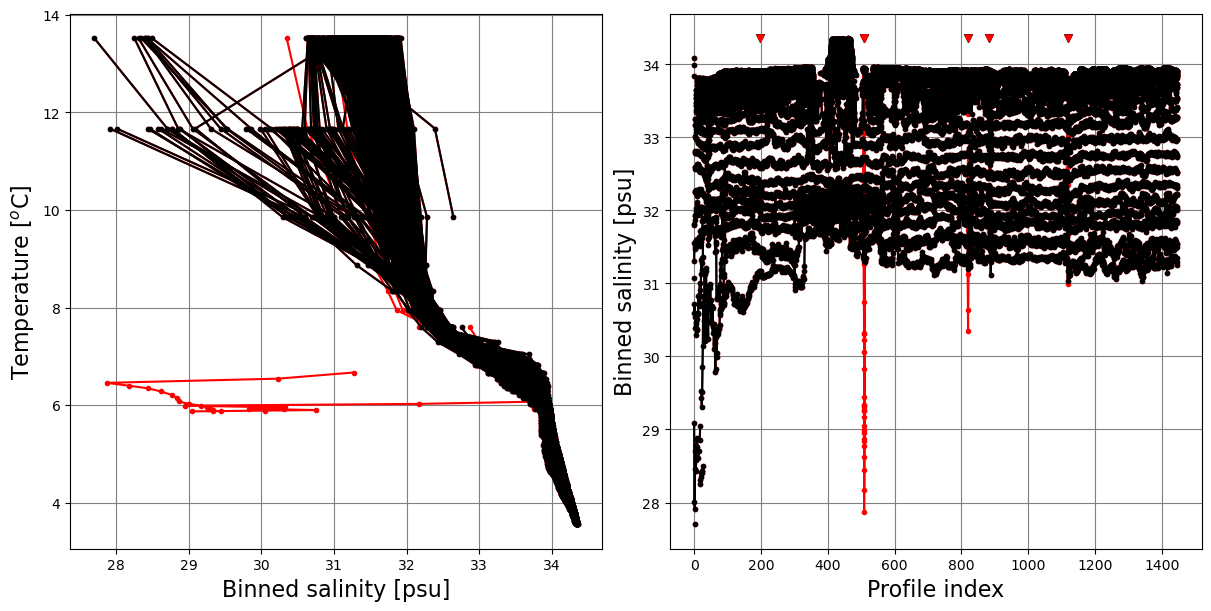

In [23]:
caption = ('Fig. 8: Binned salinity plotted as a function of temperature '  
'(left) and vs. profile index (right), \n with the salinity profiles identified ' 
'as bad due to questionable values and set to NaN shown in red and indicated by '
'the red arrows at the top of the panel on the right.')

# Function to plot the salinity field with the values identified as bad
with xr.open_dataset('SalinityGrid.nc') as sal:    
    fig, ax = plt.subplots(1,2,figsize=(12,6), 
                           constrained_layout=True)
    
    sal.salinity.plot.line(ax=ax[0],
                           y='temperature',
                           color='r',
                           marker='.',
                           add_legend=False)
    sal.salinityGood.plot.line(ax=ax[0],
                                y='temperature',
                                color='k',
                                marker='.',
                                add_legend=False)
    ax[0].set_ylabel('Temperature [$^o$C]', fontsize=16)
    ax[0].set_xlabel('Binned salinity [psu]', fontsize=16)
    ax[0].grid(axis='both', color='0.5')
    
    sal.salinity.plot.line(ax=ax[1],
                           x='profiles',
                           color='r',
                           marker='.',
                           add_legend=False)
    sal.salinityGood.plot.line(ax=ax[1],
                                x='profiles',
                                color='k',
                                marker='.',
                                add_legend=False)
    ax[1].set_ylabel('Binned salinity [psu]', fontsize=16)
    ax[1].set_xlabel('Profile index', fontsize=16)
    ax[1].grid(axis='both', color='0.5')
    x = bad_profiles
    y = np.nanmax(sal.salinity.values) + np.zeros_like(bad_profiles)
    ax[1].scatter(x,y,30,marker='v',color='k',zorder=1)
    ax[1].scatter(x,y,25,marker='v',color='r',zorder=2)
    
    print(caption)

## 2.4 Thermal lag correction

The thermal lag effect is caused by the thermal inertia of the conductivity cell affecting the temperature of the water as it passes through the cell. To determine the thermal lag correction, the temperature inside the conductivity cell is estimated, then salinity is recalculated using the estimated temperature and the measured conductivity. 

To estimate the temperature, a recursive filter is applied to the temperature field with parameters 𝛼 (the amplitude of the error), and 𝜏 (the time constant for the thermal lag). The values of 𝛼 and 𝜏 that minimize the area between pairs of profiles (each dive and subsequent climb along the glider path) are determined using a brute force minimization scheme. The quantity to be minimized is the root-mean squared difference (RMSD), which is calculated as the square root of the sum of the squared areas between pairs of salinity profiles (binned by temperature), normalized by the number of pairs of profiles.

Sea-Bird GPCTDs are pumped with a constant flow rate. As such, we expect the thermal lag to be approximately constant over the full mission, and it is sufficient to find a single value of 𝛼 and 𝜏 for the entire mission. Janzen and Creed (2011) determined a cell thermal mass correction for the GPCTD using data from a prototype CTD that sampled twice as rapidly as the GPCTD nominally samples, with a pumped flow rate of 10 ml/s. **They found 𝛼 = 0.06 and 𝜏 = 10s.**

**Our procedure for the thermal lag correction**:
1. For each mission, directly estimate the thermal lag parameters $\alpha$ and $\tau$ for that specific sensor
2. Confirm that the directly estimated value of $\tau$ is within $\pm$10s of the Janzen and Creed (2011) value of 10s
3. Quantify the improvement when using the Janzen and Creed (2011) parameters and the directly estimated parameters
4. Apply the thermal lag correction with the parameters that result in the greater improvement, and do not result in an over-correction 
5. If a given sensor has a directly estimated value of $\tau$ that is significantly higher or lower than 10s, investigate further

Note that the thermal lag correction parameters are more likely to vary slightly between individual GPCTD sensors than the alignment correction constants. 

This mission on the **Calvert Line** occurred in a highly energetic environment, so near-surface differences between a downcast and the subsequent upcast are likely to be caused by spatiotemporal variability. As such, we exclude segments of each profile in the upper water column for which the **density is $<$1025 kg/m$^3$** from the minimization routine. We also exclude the first and last **50 profiles**, which were primarily collected in the highly energetic environment of Hakai Pass. We use a subset of the remaining data, consisting of **100 pairs of profiles** equally spaced in time, to determine the correction. 

In [24]:
# Set up our constants
fn = 0.5*fs #nyquist frequency for Sea-Bird GPCTD
density_cutoff = 1023 #exclude everything less dense than this from the minimization
num_profs = 100 #number of profiles to include in the subset of data
clean_profs_start = 50 #number of profiles to exclude from the start
clean_profs_end = 50 #number of profiles to exclude from the end
dn_stdev = 1 #how many standard deviations from the mean the area between downcasts can be

# Load time series
ts = ds1.copy(deep=True)
ts = ts.assign_coords(pind=ts.profile_index) #add a profile index coordinate
tot_profs = int(np.nanmax(ts.profile_index.values))
print('Total number of profiles:', tot_profs)

# Overwrite conductivity in our working xarray with the clean, aligned conductivity field
ts['conductivity'] = ts.conductivityClean

# Determine pairs of profiles for the selected subset of data
ts_sub, profile_bins, profile_bins_all, direction = pgs.profile_pairs(
    ts, clean_profs_start, clean_profs_end, num_profs, bad_profiles
)

# Identify boolean index for application of density cutoff 
density_bool = ts_sub.density>=density_cutoff

Total number of profiles: 1447


In [25]:
#Determine the RMSD for the subset of profiles with no corrections applied
alpha_0 = 0
tau_0 = 0
area_bad = np.full_like(profile_bins_all, False, dtype=bool)

#Run brute force optimization that applies the TS_diff function to dataset ts_sub
RMSD_0 = pgs.TS_diff((alpha_0, tau_0),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub) 
area_0, p_ind_0 = pgs.TS_diff((alpha_0, tau_0),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

print('RMSD for uncorrected data = ', RMSD_0)

RMSD for uncorrected data =  0.2502798371385725


We exlude profiles from the correction for which the area between subsequent downcasts is more than one standard deviation from the mission mean. This ensures that no data crossing fronts or intrusions is included in the correction, in line with the key assumption that a downcast and the subsequent upcast be identical (Fig. 9). 

Furthermore, we impose a cutoff for the area between pairs of profiles that will be included in the subset used to estimate the parameters. Any pair of profiles whose area is more than 3 standard deviations away from the mean will be excluded from the determination of the RMSD. This ensures that a small number of anomalous profiles do not bias the results.

In [ ]:
#Determine the area between subsequent downcasts to restrict profiles included
dn_area, area_bad = pgs.TS_preprocess(
    density_bool, dn_stdev, 
    profile_bins, profile_bins_all, 
    direction, ts_sub)
print('Max and min area between downcasts = ', np.nanmax(dn_area), np.nanmin(dn_area))

ts_bad = ts_sub.where(
    ts_sub.profile_index.isin(
        profile_bins_all[area_bad]), 
        drop=True)
prof_list = ts_bad.profile_index
print('List of profiles to exclude:', np.unique(prof_list.values))

In [ ]:
prof_list = ts_bad.profile_index

def plot_correctedsalinitygrid(sal, fig, ax0, prof_start, prof_end, prof_list, v_min, v_max, cp_label, caption=''):
# Function to plot the uncorrected and corrected salinity, gridded with temperature
    cp = ax0.pcolormesh(sal.profile_index,
                       sal.temperature,
                       sal.salinityClean,
                       cmap=cmocean.cm.haline,
                       vmin=v_min,vmax=v_max)
    fig.colorbar(cp, ax=ax0, label=cp_label)
    if np.any(prof_list):
        x=prof_list
        y=sal.temperature[-1].values+np.zeros_like(prof_list)
        ax0.scatter(x,y,30,marker='v',color='k')
        ax0.scatter(x,y,25,marker='v',color='r')

    ax0.set_ylabel('Temperature [$^o$C]', fontsize=16)
    ax0.set_xlabel('Profile Index', fontsize=16)
    ax0.grid(color='0.5')
    ax0.set_xlim(prof_start, prof_end)

    if caption:
        print(caption)

caption = ('Fig. 9: Salinity, gridded in temperature space, for different segments of the '
           'deployment. The top panels show the outgoing leg of the deployment, the middle '
           'panels show profiles in water deeper than 1000m, with two different sets of '
           'colorbar limits, and the bottom panels show the return leg of the deployment. '
           'Red arrows indicate the profiles identified for exclusion using restrictions '
           'based on the area between subsequent downcasts.')
fig, ax = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

prof_start = 101
prof_end = 200
plot_correctedsalinitygrid(sal, fig, ax[0][0], prof_start, prof_end, prof_list, 31.5, 32.6, 
                               'Uncorrected salinity [psu]')
prof_start = 201
prof_end = 400
plot_correctedsalinitygrid(sal, fig, ax[0][1], prof_start, prof_end, prof_list, 31.5, 32.6, 
                               'Uncorrected salinity [psu]')

prof_start = 401
prof_end = 475
plot_correctedsalinitygrid(sal, fig, ax[1][0], prof_start, prof_end, prof_list, 33.8, 34.1, 
                               'Uncorrected salinity [psu]')
plot_correctedsalinitygrid(sal, fig, ax[1][1], prof_start, prof_end, prof_list, 32, 32.6, 
                               'Uncorrected salinity [psu]')

prof_start = 476
prof_end = 650
plot_correctedsalinitygrid(sal, fig, ax[2][0], prof_start, prof_end, prof_list, 31.5, 32.6, 
                               'Uncorrected salinity [psu]')
prof_start = 651
prof_end = tot_profs
plot_correctedsalinitygrid(sal, fig, ax[2][1], prof_start, prof_end, prof_list, 31.5, 32.6, 
                               'Uncorrected salinity [psu]',caption=caption)

We now determine our filter coefficients 𝛼 and 𝜏 to apply the correction. Given the recommended values of 𝛼 = 0.06 and 𝜏 = 10s, **we try values of 𝜏 between 1s and 35s, and values of 𝛼 between 0.001 and 0.150** for our parameter space (Fig. 10). 

In [ ]:
#Set up your parameter ranges for alpha and tau and run the minimization
alpha_vec1 = slice(1,152,20)
tau_vec1 = slice(1,37,5)
print('Ranges of alpha and tau being tested are: ', alpha_vec1, tau_vec1)

#Run brute force optimization that applies the TS_diff function to dataset ts_sub
res = optimize.brute(pgs.TS_diff, 
                     (alpha_vec1, tau_vec1), 
                     args=(fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub), 
                     full_output=True, finish=None, workers=1)

RMSD_1 = res[1]
RMSD_grid_1 = res[3]
tau_1 = res[2][1][RMSD_grid_1==RMSD_1]
alpha_1 = res[2][0][RMSD_grid_1==RMSD_1] 

print('Tau = ', tau_1-1)
print('Alpha = ', (alpha_1-1) / 1e3)
print('RMSD = ', RMSD_1)

In [ ]:
plt.pcolormesh(np.arange(tau_vec1.start,tau_vec1.stop,tau_vec1.step),
               np.arange(alpha_vec1.start,alpha_vec1.stop,alpha_vec1.step) / 1e3,
               RMSD_grid_1, vmin=np.nanmin(RMSD_grid_1), vmax=np.nanmax(RMSD_grid_1)-(np.nanmax(RMSD_grid_1)/3))
plt.xlabel('Tau')
plt.ylabel('Alpha')
plt.colorbar(label='Root mean squared difference in salinity [g/kg]')
plt.plot(10,0.06,'k*',markersize=25);
print('Fig. 10a: Values of the root-mean squared difference for each parameter value used during ' ,
      'the grid search to minimize the area between pairs of profiles. Note that high values of ' ,
      'the RMSD have been saturated (yellow) to better show the minimum (dark blue). The black star ' ,
     'shows the Janzen and Creed (2011) values.')

We see that there is a fairly wide band of 'good' values where the RMSD is low, with **the best directly determined parameter values being $\alpha$=0.02 and $\tau$=35s**. This value of $\tau$ is larger than Janzen and Creed (2011), while $\alpha$ is smaller, however the Janzen and Creed (2011) values fall well within the band of low RMSD.  

We now confirm that this band of 'good' values is the same for profiles taken from 1) the early part of the mission, using profiles from the first quarter of all profiles collected, and 2) the later part of the mission, using profiles from the last quarter of all profiles collected. 

In [ ]:
#Set up your parameter ranges for alpha and tau and run the minimization
alpha_vec1 = slice(1,152,20)
tau_vec1 = slice(1,37,5)
print('Ranges of alpha and tau being tested are: ', alpha_vec1, tau_vec1)

#Run brute force optimization that applies the TS_diff function to dataset ts_sub
res = optimize.brute(pgs.TS_diff, 
                     (alpha_vec1, tau_vec1), 
                     args=(fn,density_bool,area_bad,profile_bins[0:int(len(profile_bins)/4)+1],profile_bins_all,ts_sub), 
                     full_output=True, finish=None, workers=1)

RMSD_1 = res[1]
RMSD_grid_1 = res[3]
tau_1 = res[2][1][RMSD_grid_1==RMSD_1]
alpha_1 = res[2][0][RMSD_grid_1==RMSD_1] 

print('Tau = ', tau_1-1)
print('Alpha = ', (alpha_1-1) / 1e3)
print('RMSD = ', RMSD_1)

In [ ]:
plt.pcolormesh(np.arange(tau_vec1.start,tau_vec1.stop,tau_vec1.step),
               np.arange(alpha_vec1.start,alpha_vec1.stop,alpha_vec1.step) / 1e3,
               RMSD_grid_1, vmin=np.nanmin(RMSD_grid_1), vmax=np.nanmax(RMSD_grid_1)-(np.nanmax(RMSD_grid_1)/3))
plt.xlabel('Tau')
plt.ylabel('Alpha')
plt.colorbar(label='Root mean squared difference in salinity [g/kg]')
plt.plot(10,0.06,'k*',markersize=25);
print('Fig. 10b: Values of the root-mean squared difference for each parameter value used during ' ,
      'the grid search to minimize the area between pairs of profiles for the first quarter of the ',
      'mission. Note that high values of ' ,
      'the RMSD have been saturated (yellow) to better show the minimum (dark blue). The black star ' ,
     'shows the Janzen and Creed (2011) values.')

In [ ]:
#Set up your parameter ranges for alpha and tau and run the minimization
alpha_vec1 = slice(1,152,20)
tau_vec1 = slice(1,37,5)
print('Ranges of alpha and tau being tested are: ', alpha_vec1, tau_vec1)

#Run brute force optimization that applies the TS_diff function to dataset ts_sub
res = optimize.brute(pgs.TS_diff, 
                     (alpha_vec1, tau_vec1), 
                     args=(fn,density_bool,area_bad,profile_bins[int(3*len(profile_bins)/4)+1:],profile_bins_all,ts_sub), 
                     full_output=True, finish=None, workers=1)

RMSD_1 = res[1]
RMSD_grid_1 = res[3]
tau_1 = res[2][1][RMSD_grid_1==RMSD_1]
alpha_1 = res[2][0][RMSD_grid_1==RMSD_1] 

print('Tau = ', tau_1-1)
print('Alpha = ', (alpha_1-1) / 1e3)
print('RMSD = ', RMSD_1)

In [ ]:
plt.pcolormesh(np.arange(tau_vec1.start,tau_vec1.stop,tau_vec1.step),
               np.arange(alpha_vec1.start,alpha_vec1.stop,alpha_vec1.step) / 1e3,
               RMSD_grid_1, vmin=np.nanmin(RMSD_grid_1), vmax=np.nanmax(RMSD_grid_1)-(np.nanmax(RMSD_grid_1)/6))
plt.xlabel('Tau')
plt.ylabel('Alpha')
plt.colorbar(label='Root mean squared difference in salinity [g/kg]')
plt.plot(10,0.06,'k*',markersize=25);
print('Fig. 10c: Values of the root-mean squared difference for each parameter value used during ' ,
      'the grid search to minimize the area between pairs of profiles for the last quarter of the ',
      'mission. Note that high values of ' ,
      'the RMSD have been saturated (yellow) to better show the minimum (dark blue). The black star ' ,
     'shows the Janzen and Creed (2011) values.')

For the first and last quarter of the mission, the **values of $\tau$=35s and $\alpha$=0.02** are unchanged from those for the mission as a whole, and the location of the band of low values is the same. 

Since our directly determined parameters **$\tau$=35s and $\alpha$=0.02** fall in the same band of low RMSD values as the Janzen and Creed (2011) parameters, i.e., they result in only marginally lower RMSD overall compared to the Janzen and Creed (2011) parameters, we will skip quantifying the improvement for our directly determined values, and use the Janzen and Creed (2011) parameters for the final correction.

**Quantifying improvement for the Janzen and Creed (2011) parameters**: 

In [ ]:
# Calculate the corrected fields and corrected gridded salinity for plotting
alpha_2 = 60
tau_2 = 10

ts = ds1.copy(deep=True) #Use the aligned conductivity field
ts = ts.assign_coords(pind=ts.profile_index) #add a profile index coordinate

# Overwrite conductivity with the clean, aligned conductivity field
ts['conductivity'] = ts.conductivityClean

ts_final, x0 = pgs.TS_apply((alpha_2, tau_2), fn, bad_profiles, ts)

# Calculate the gridded salinity field for the corrected data
ts = ts_final.copy(deep=True)
ts['salinity'] = ts['salinity_adjusted']
ts['temperature'] = ts['temperature_adjusted']
ts['density'] = ts['density_adjusted']
sal_final = pgs.get_salinity_grid(
    ts.load(), Tmean, clean_profs, flag_stdev, clean_stdev, clean_cutoff, dtbin
)

The effect of applying the Janzen and Creed (2011) thermal lag correction on the salinity data is shown in Figure 11. It's clear that the correction has **significantly reduced the up-down asymmetry** between pairs of profiles, throughout the water column. 

In [ ]:
sal = xr.open_dataset('SalinityGrid.nc')

def plot_anomalysalinitygrid(sal, sal_final, fig, ax0, prof_start, prof_end, 
                             v_min, v_max, cp_label,caption=''):
# Function to plot the difference between the uncorrected and corrected salinity, 
# gridded with temperature
    cp = ax0.pcolormesh(sal_final.profile_index,
                       sal_final.temperature,
                       sal_final.salinityClean-sal.salinityClean,
                       cmap=cmocean.cm.haline,
                       vmin=v_min,vmax=v_max)
    fig.colorbar(cp, ax=ax0, label=cp_label)
    ax0.set_xlim(prof_start, prof_end)
    ax0.set_ylabel('Temperature [$^o$C]', fontsize=16)
    ax0.set_xlabel('Profile Index', fontsize=16)
    ax0.grid(color='0.5')

    plt.show()
    if caption:
        print(caption)

prof_start = 400
prof_end = 475

caption = ('Fig. 11: Clean salinity (with bad profiles removed), plotted vs. temperature and '
           'profile index. Profiles deeper than 1000m are shown. The uncorrected salinity is '
           'shown in the left panels, the corrected salinity is shown in the middle panels, and '
           'the difference between the two is shown in the right panel. The bottom row is identical '
           'to the top row, but with the colorscale adjusted to show depths within the thermocline.')

fig, ax = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
ax[0][2].set_visible(False)

plot_correctedsalinitygrid(sal, fig, ax[0][0], prof_start, prof_end, [], 31.5, 32, 
                               'Uncorrected salinity [psu]')
plot_correctedsalinitygrid(sal_final, fig, ax[0][1], prof_start, prof_end, [], 31.5, 32, 
                               'Corrected salinity [psu]')
plot_correctedsalinitygrid(sal, fig, ax[1][0], prof_start, prof_end, [], 32, 32.6, 
                               'Uncorrected salinity [psu]')
plot_correctedsalinitygrid(sal_final, fig, ax[1][1], prof_start, prof_end, [], 32, 32.6, 
                               'Corrected salinity [psu]')
plot_anomalysalinitygrid(sal, sal_final, fig, ax[1][2], prof_start, prof_end, -0.05, 0.05, 
                             'Difference in salinity [psu]',caption)

To quantify the magnitude of the improvement, Figure 12 shows the area between all pairs of profiles considered, plotted versus profile index and as a histogram, as well as the difference in area between the corrected and uncorrected data. 

In [ ]:
# Calculate the area between pairs of profiles for the corrected data
area_2, p_ind_2 = pgs.TS_diff((alpha_2, tau_2),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

# Calculate the area between pairs of profiles for the uncorrected data
area_0, p_ind_0 = pgs.TS_diff((0, 0),
                     fn,density_bool,area_bad,profile_bins,profile_bins_all,ts_sub,
                     ret_err=False) 

def plot_correctedarea(profile_index, area_0, area_final, n_bins, caption=''):
# Function to plot the area between pairs of profiles, vs. profile index and as a historgram
    fig, ax = plt.subplots(2, 2, figsize=(12, 8), 
                           constrained_layout=True)

    ax[0][0].plot(profile_index, (area_0),
               color='gray', marker='.', linestyle='None');
    ax[0][0].plot(profile_index, (area_final),
               '.k', linestyle='None');
    ax[0][0].set_ylabel('Area [$^o$C g/kg]', fontsize=16)
    ax[0][0].set_xlabel('Profile index', fontsize=16)
    ax[0][0].grid(color='0.5')

    ax[1][0].plot(profile_index, 
               (area_0)-(area_final),
               color='blue', marker='.', linestyle='None');
    ax[1][0].set_ylabel('Area anomaly [$^o$C g/kg]', fontsize=16)
    ax[1][0].set_xlabel('Profile index', fontsize=16)
    ax[1][0].grid(color='0.5')

    ax[0][1].hist(area_0, n_bins, density=True, histtype='bar', 
                  color='gray', label='uncorrected')
    ax[0][1].hist(area_final, n_bins, density=True, histtype='bar', 
                  color='black', label='corrected')
    ax[0][1].legend(prop={'size': 10})
    ax[0][1].set_xlabel('Area [$^o$C g/kg]', fontsize=16)
    ax[0][1].grid(color='0.5')

    ax[1][1].hist(area_0-area_final, n_bins, density=True, histtype='bar', 
                  color='blue', label='uncorrected')
    ax[1][1].set_xlabel('Area anomaly [$^o$C g/kg]', fontsize=16)
    ax[1][1].grid(color='0.5')

    if caption:
        plt.show()
        print(caption)
        
n_bins = 20
caption = ('Fig. 12: Area between pairs of salinity profiles, calculated in temperature-salinity space, ' 
         'plotted vs. profile index number (left) and as a histogram (right), for the uncorrected ' 
         'salinity field (grey) and the corrected salinity field (black), and as an anomaly between ' 
         'the uncorrected and corrected fields (bottom row, blue).')

plot_correctedarea(p_ind_2, area_0, area_2, n_bins, caption)

print('Total area mean =', np.nanmean(area_2))
print('Total area anomaly mean =', np.nanmean(area_0-area_2))

**Summary of thermal lag correction**

Since the quantitative improvement is only marginally larger for our directly determined parameters, we use the **Janzen and Creed (2011)** parameters for our final thermal lag correction, which results in a significant improvement in the up-down asymmetry in the salinity field (Figure 13). 

In [ ]:
# Calculate the corrected fields 
alpha_2 = 60
tau_2 = 10

ts = ds1.copy(deep=True) #Apply final correction to the aligned fields
ts = ts.assign_coords(pind=ts.profile_index) #add a profile index coordinate
# Overwrite conductivity with the clean, aligned conductivity field
ts['conductivity'] = ts.conductivityClean

ts_final, x0 = pgs.TS_apply((alpha_2, tau_2), fn, bad_profiles, ts)

In [ ]:
#Compare the uncorrected and corrected data in T-S space

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.min(ds1.salinity)-0.5, 
                      np.max(ds1.salinity)+0.5, 1000)
T_range = np.linspace(np.min(ds1.temperature)-1, 
                      np.max(ds1.temperature)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

# Apply the correction to a small subset of the full dataset for plotting
ts_f = ts.copy()
for bad in bad_profiles:
    ts_f = ts_f.where(~(ts_f.profile_index==bad))
ts_f = ts_f.where(np.isfinite(ts_f.temperature + 
                                  ts_f.conductivityClean))
ts_f = ts_f.where(ts_f.conductivityClean>=0)
ts_f = ts_f.isel(time=range(46400*4, 46400*6))

ts_ff, xf = pgs.TS_apply((alpha_2, tau_2), fn, bad_profiles, ts.isel(time=range(46400*4, 46400*6)))

#Plotting
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

ind = np.where(ts_f.profile_direction.values== 1)[0]
ax[0].plot(ts_f.salinity[ind], ts_f.temperature[ind], 'b.', markersize=1)

ind = np.where(ts_f.profile_direction.values == -1)[0]
ax[0].plot(ts_f.salinity[ind], ts_f.temperature[ind], 'r.', markersize=1)

CS = ax[0].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[0].clabel(CS, CS.levels, inline=True, fontsize=10)

ax[0].set_ylabel('Temperature [$^o$C]')
ax[0].set_xlabel('Salinity [psu]')
ax[0].set_title('Uncorrected')
ax[0].set_xlim(30.5, 34.5)
ax[0].grid()

ind = np.where(ts_ff.profile_direction.values== 1)[0]
ax[1].plot(ts_ff.salinity_adjusted[ind], ts_ff.temperature_adjusted[ind], 'b.', markersize=1)

ind = np.where(ts_ff.profile_direction.values==-1)[0]
ax[1].plot(ts_ff.salinity_adjusted[ind], ts_ff.temperature_adjusted[ind], 'r.', markersize=1)

CS = ax[1].contour(S_range, T_range, density_grid,
                np.arange(1014,np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax[1].clabel(CS, CS.levels, inline=True, fontsize=10)

ax[1].set_ylabel('Temperature [$^o$C]')
ax[1].set_xlabel('Salinity [psu]')
ax[1].set_title('Corrected')
ax[1].set_xlim(30.5, 34.5)
ax[1].grid()

print('Fig 13: Temperature-salinity diagrams for a subset of all profiles, '
      'showing the difference between upcasts (red) and downcasts (blue), '
      'for the data without the thermal lag correction applied (left panel) and '
      'the data with the thermal lag correction applied (right panel).')

# 3.0 Summary of corrections applied to delayed mode data for this mission
1. Identification of anomalous conductivity values:
   * Anomalous conductivity values at the surface were set to NaN, as were some conductivity spikes deeper in the water column, between the surface and 250 m. 
3. Sensor alignment correction
   * Following Janzen and Creed (2011), temperature was advanced by +0.5 s relative to pressure, while conductivity was advanced by +0.4 s relative to pressure.
   * These values were confirmed by directly estimating the time constant using the methodology of Ferrari and Rudnick (2000).
   * The correction produced a small but quantifiable reduction in small-scale unphysical variations in the salinity field in the region of strong temperature and conductivity gradients.
5. Identification of questionable salinity profiles
   * Eight salinity profiles were flagged as 'bad' and their values set to NaN: profile indices 196, 226, 243, 509, 510, 820, 884, and 1119.
7. Thermal lag correction
   * The directly determined values for the thermal lag correction produced an improvement that was only marginally greater than the recommended values from Janzen and Creed (2011).
   * The final thermal lag correction was applied using the Janzen and Creed (2011) values of $\alpha$=0.06 and $\tau$=10s.
   * The correction reduced the root-mean squared difference for the area between between pairs of profiles by 175%, and adjusted the salinity field by over 0.05 psu in the thermocline.

In [ ]:
# Set up and save our final datasets
ts0 = pgs.get_timeseries(deploy_prefix, deploy_name)
ts0['conductivity_adjusted'] = ts_final.conductivity.copy()
ts0.conductivity_adjusted.values = ts_final.conductivityClean.values
ts0['conductivity_adjusted'].attrs['comment'] = 'corrected conductivity'
ts0['conductivity_adjusted'].attrs['processing_report'] = processing_report
ts0['conductivity_adjusted'].attrs['processing_date'] = processing_date
ts0['conductivity_adjusted'].attrs['processing_date'] = processing_protocol
ts0['temperature_adjusted'] = ts_final.temperature
ts0['temperature_adjusted'].attrs['comment'] = 'corrected temperature'
ts0['temperature_adjusted'].attrs['processing_report'] = processing_report
ts0['temperature_adjusted'].attrs['processing_date'] = processing_date
ts0['temperature_adjusted'].attrs['processing_date'] = processing_protocol
ts0['salinity_adjusted'] = ts_final.salinity
ts0['salinity_adjusted'].attrs['comment'] = 'corrected salinity'
ts0['salinity_adjusted'].attrs['method'] = ' '
ts0['salinity_adjusted'].attrs['processing_report'] = processing_report
ts0['salinity_adjusted'].attrs['processing_date'] = processing_date
ts0['salinity_adjusted'].attrs['processing_protocol'] = processing_protocol
ts0['density_adjusted'] = ts_final.density
ts0['density_adjusted'].attrs['comment'] = 'density from corrected salinity [psu] and temperature [degC]'
ts0['density_adjusted'].attrs['method'] = ' '

Fig. 16: The corrected temperature and salinity fields shown in a T-S diagram with density contours (left) and the corrected salinity field plotted vs. depth and time (right).


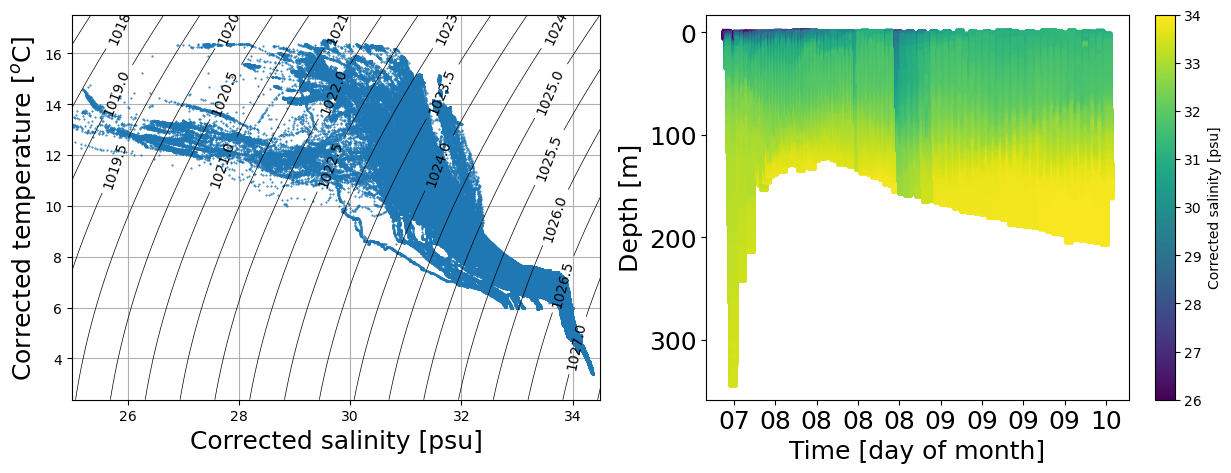

In [39]:
# Visualize the final data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# T-S diagram for fully corrected data
ax0 = ax[0]
ax0.plot(ts0.salinity_adjusted,ts0.temperature_adjusted,'.',markersize=1)

#Create a density grid to contour plot isopycnals
S_range = np.linspace(np.nanmin(ts0.salinity_adjusted)-0.5, 
                      np.nanmax(ts0.salinity_adjusted)+0.5, 1000)
T_range = np.linspace(np.nanmin(ts0.temperature_adjusted)-1, 
                      np.nanmax(ts0.temperature_adjusted)+1, 1000)
S_grid, T_grid = np.meshgrid(S_range, T_range)
density_grid = seawater.eos80.dens0(S_grid, T_grid)

CS = ax0.contour(S_range, T_range, density_grid,
                np.arange(1014,
                          np.round(np.max(density_grid)),0.5),
                colors='k', linewidths=0.5);
ax0.clabel(CS, CS.levels, inline=True, fontsize=10)
ax0.set_xlabel('Corrected salinity [psu]', fontsize=18)
ax0.set_ylabel('Corrected temperature [$^o$C]', fontsize=18)
ax0.set_xlim(25,34.5)
ax0.grid()

ax1 = ax[1]
fld = ts0.salinity_adjusted
dp = ts0.depth[0:min([len(fld), 200000])]
tm = ts0.time[0:min([len(fld), 200000])]
fld = fld[0:min([len(fld), 200000])]

sc = ax1.scatter(tm[~np.isnan(fld)], dp[~np.isnan(fld)], s=25, c=fld[~np.isnan(fld)], marker='s', vmin=26, vmax=34)
cb = fig.colorbar(sc, ax=ax1, orientation='vertical', label='Corrected salinity [psu]')
ax1.set_xlabel('Time [day of month]', fontsize=18)
ax1.set_ylabel('Depth [m]', fontsize=18)
ax1.invert_yaxis()
ax1.tick_params(labelsize=18)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

print('Fig. 14: The corrected temperature and salinity fields '
      'shown in a T-S diagram with density contours (left) and the corrected '
      'salinity field plotted vs. depth and time (right).')

In [41]:
# Save our final datasets
#ts0.to_netcdf(deploy_prefix+deploy_name+'_adjusted.nc')
print('Corrected data saved to file: '+deploy_prefix+deploy_name+'_adjusted.nc')

Corrected data saved to file: ./dfo-bb046-20220707/dfo-bb046-20220707_adjusted.nc


In [40]:
ts0

<xarray.Dataset>
Dimensions:                (time: 1759051)
Coordinates:
  * time                   (time) datetime64[ns] 2022-07-07T16:45:19.20499993...
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
    pind                   (time) float64 -0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0
Data variables: (12/22)
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    conductivity           (time) float64 ...
    temperature            (time) float64 ...
    pressure               (time) float64 ...
    ...                     ...
    density                (time) float64 ...
    potential_temperature  (time) float64 ...
    conductivity_adjusted  (time) float64 3.095 2.793 2.85 2.926 ... nan nan nan
    temperature_adjusted   (time) float64 14.18 14.69 14.46 ... nan nan nan
    salinity_adjusted      (time) float64 24.86 21.92 22.54 ... nan nan nan
    density_adjusted       (time) float64 1.018e+03 1.016e+03 ... nan nan
Attributes: (12/67)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Calvert Island deployment
    contributor_name:          James Pegg, Jody Klymak, Tetjana Ross, Jennife...
    ...                        ...
    summary:                   Glider deployed near Calvert Island BC as part...
    time_coverage_end:         2022-07-28T03:28:20.381000000
    time_coverage_start:       2022-07-07T16:45:19.205000000
    title:                     dfo-bb046-20220707T1645
    transmission_system:       IRIDIUM
    wmo_id:                    4803918

jupyter nbconvert CTD_dfo-mike579-20210704_v2.ipynb --to=webpdf --TemplateExporter.exclude_input=True